In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import sys
sys.path.append('./models/')
from SIR import *
from exponential_regression import *


In [10]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])

df = pd.read_csv('deaths_and_infections.csv')

# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
n_infected=np.array(df['n_infected'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))
mob_shifted=np.concatenate((np.array([ 0 for i in range(17)]), mobility))
mob_17_days_ahead=(np.array([mob_shifted[i-17] for i in range(17, len(mob_shifted)-17)]))

In [11]:
data =[ new_deaths, n_infected, mob_17_days_ahead ]

In [12]:

class Multi_Dimensional_Model: 
    def __init__(self) :
        self.trained=False
    def reinitialize(self): 
        self.trained=False
        self.data=None
        self.train_dates=None
        self.model=None
    def train(self, train_dates, data):
        self.train_dates=train_dates
        self.data=data # to be implemented in the child class
    def predict(self, reach, alphas):
        pass # to be implemented in the child class 

    def plot(self, reach, alpha, title=None): 
        assert self.trained, 'The model has not been trained yet'
        prediction, intervals = self.predict(reach, alpha)
        ci_low=[max(0, intervals[0][i]) for i in range(len(intervals[0]))]
        ci_high=intervals[1]
        plt.plot([i for i in range(len(self.data[0]))], self.data[0], label='real data')
        plt.plot([i for i in range(len(self.data[0]), len(self.data[0]) + reach)] , prediction, label='forecast ')
        plt.fill_between([i for i in range(len(self.data[0]), len(self.data[0]) + reach )], ci_low, ci_high, color='black', alpha=.3, label='confidence interval at ' + str(round((1-alpha)*100)) + '%')
        plt.legend()
        plt.axvline(len(self.data[0]), linestyle='--')
        plt.xlim(0,len(self.data[0])+reach)
        plt.title(title)
        plt.show()

In [13]:


def exponential_function_m(X, a, b,c, d, e): 
    i, n_infected, mobility = X

    return a * np.exp(b * mobility + c * i+ d * n_infected) +e



def grad_theta_h_m(theta, x): 
    a=theta[0]
    b=theta[1]
    c=theta[2]
    d=theta[3]
    e=theta[4]
    grad=np.zeros(5)
    i, n_infected, mobility = x
    grad[0]=np.exp(b * mobility +c* i+ d * n_infected)
    grad[1]=a * np.exp(b * mobility +c* i+ d * n_infected) * mobility
    grad[2]=a * np.exp(b * mobility +c* i+ d * n_infected) * i
    grad[3]=a * np.exp(b * mobility +c* i+ d * n_infected) * n_infected
    grad[4]=1
    return grad 

In [14]:

class MultiDimensionalExponentialRegression(Multi_Dimensional_Model): 
    def train(self, train_dates, data):
        self.data=data
        maxi=np.max(data[1])
        self.n_infected_normalized=np.array([i/maxi for i in data[1]]) # to avoid too big values in the exponential function
        n_infected_normalized=self.n_infected_normalized
        train_dates=np.array(train_dates)
        self.train_dates=train_dates
        min=len(data[0])-30
        max=len(data[0])-1
        interval=[i for i in range(min,max)]
        self.interval=interval
        self.p, self.cov =curve_fit(exponential_function_m, (train_dates[interval], n_infected_normalized[interval], data[2][interval]),data[0][interval],  p0=[ 1,1, 1, 1,1], maxfev = 1000000)
        self.trained=True


    def predict(self, reach, alpha, method='covariance'):
        assert self.trained, 'The model has not been trained yet'
        a=self.p[0]
        b=self.p[1]
        c=self.p[2]
        d=self.p[3]
        e=self.p[4]
        window_prediction=np.array([i for i in range(len(self.train_dates), len(self.train_dates) + reach )])
        self.window_prediction=window_prediction
        last_value_of_mobility=self.data[2][-1]
        last_value_of_infected=self.n_infected_normalized[-1]
        prediction_interval=np.array([window_prediction, np.array([last_value_of_infected for i in range(len(window_prediction))]), np.array([last_value_of_mobility for i in range(len(window_prediction))])])
        prediction=exponential_function_m(prediction_interval,a,b,c,d,e)
        self.prediction=prediction

        perr = np.sqrt(np.diag(self.cov))
        self.perr=perr     
        ci_low=[]
        ci_high=[]
        grads= []
        vars=[]
        for i in range(len(prediction)):
            index = self.window_prediction[i] 
            n_infected=last_value_of_infected
            mobility=last_value_of_mobility
            grad=grad_theta_h_m(self.p, [index, n_infected, mobility])
            grads.append(grad)
            varhtheta=self.cov 
            varprediction=np.matmul(np.matmul(grad.transpose(), varhtheta), grad)
            vars.append(varprediction)
            down = scipy.stats.norm.ppf(alpha/2, loc=prediction[i], scale=np.sqrt(varprediction))
            ci_low.append(down)
            up = scipy.stats.norm.ppf(1-(alpha/2), loc=prediction[i], scale=np.sqrt(varprediction))
            ci_high.append(up)
        self.ci_low=ci_low
        self.ci_high=ci_high
        self.grads=grads
        self.vars=vars
        return prediction, [ci_low, ci_high]




In [15]:
myexp=ExponentialRegression()
myexp.train(dates_of_pandemic_train, data_train[0])

In [16]:
myexp_multi=MultiDimensionalExponentialRegression()
myexp_multi.train(dates_of_pandemic_train, data_train)

covariance method


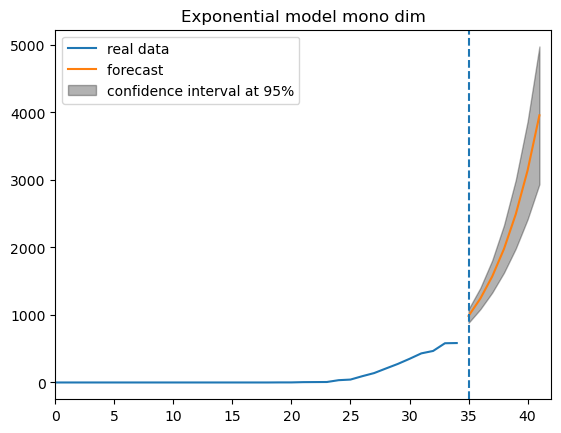

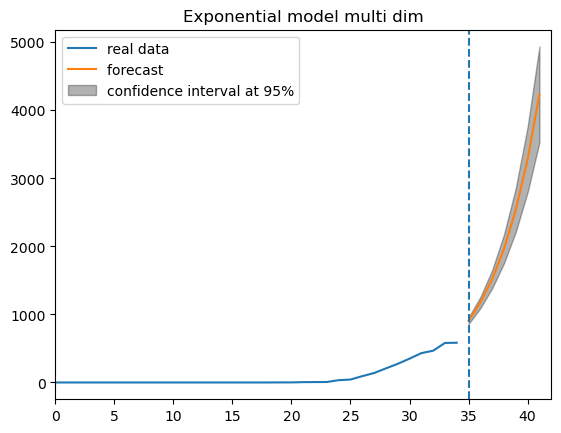

In [17]:
myexp.plot(7, 0.05, title='Exponential model mono dim')
myexp_multi.plot(7, 0.05, title='Exponential model multi dim')

In [18]:

def run_sir_m(x0, a, b , gamma,d, mobility , dt):
    t=len(mobility)
    x=x0
    S=[x[0]]
    I=[x[1]]
    R=[x[2]]
    D=[x[3]] # deads 
    n_iter=int(t/dt)
    N=sum(x0)
    for i in range(n_iter):
        todays_mobility=mobility[int(i*dt)]
        beta=a*todays_mobility+b
        x=x+dt*derive(x, beta, N, gamma, d)
        S.append(x[0])
        I.append(x[1])
        R.append(x[2])
        D.append(x[3])
    s_final=[]
    i_final=[]
    r_final=[]
    d_final=[]
    time=np.linspace(0, t, int(t/dt) )
    for i in range(len(time)-1):
        if abs(time[i]-int(time[i]))<dt: 
            s_final.append(S[i])
            i_final.append(I[i])
            r_final.append(R[i])
            d_final.append(D[i])
    return s_final, i_final, r_final, d_final

def sir_for_optim_m( x, a, b ,d, mobility): # returns first the number of deaths and then the number of total infected
    
    s_0=1000000 -1
    i_0=1
    r_0=0
    d_0=0
    x0=np.array([s_0, i_0, r_0, d_0])
    dt=0.001

    S, I, R, D = run_sir_m(x0, a, b , 0.2,d, mobility ,   dt)
    zer=np.array([0])
    d_arr=np.array(D)
    I_arr=np.array(I)
    return np.concatenate((differenciate(np.concatenate((zer,d_arr))), I_arr))


In [19]:
def sir_for_optim_normalized(x, a, b, d, mobility, new_deaths, n_infected, taking_I_into_account=True): # returns firts the number of deaths and then the number of total infected
    I_and_D=sir_for_optim_m(x, a, b, d, mobility)
    I=I_and_D[len(I_and_D)//2:]
    D=I_and_D[:len(I_and_D)//2]
    if taking_I_into_account: 
        return np.concatenate((D/np.max(new_deaths), I/np.max(n_infected)))
    else:
        return D



In [20]:
from scipy.optimize import curve_fit

def f(interval, alpha, beta): 
    return np.concatenate((np.array(alpha*interval-x_obj) , np.array(beta*interval**2-y_obj)))

x_obj = np.array([2, 4, 6, 8, 10])
y_obj = np.array([1, 12, 27, 48, 75])
interval = np.array([1, 2, 3, 4, 5])

popt, pcov = curve_fit(f, interval, np.concatenate((x_obj, y_obj)), p0=[2, 1])

In [21]:


def grad_theta_h_theta(x0, theta, mob_predicted ): 
    reach=len(mob_predicted) 
    grad=np.zeros((len(theta), reach))
    for i in range(len(grad)): ##################################
        theta_plus=theta.copy()
        theta_plus[i]+=0.0001
        mob_extended=np.concatenate((mob_predicted, np.array([mob_predicted[-1]])))
        _, _, _, deads_grad = run_sir_m([x0[0], x0[1], x0[2], x0[3]], theta_plus[0], theta_plus[1], 0.2,theta_plus[2] , mob_extended, 0.001)
        _, _, _, deads= run_sir_m([x0[0], x0[1], x0[2], x0[3]], theta[0], theta[1], 0.2, theta[2], mob_extended, 0.001)
        d_arr_grad= np.array(differenciate(np.array(deads_grad)))
        d_arr=np.array(differenciate(np.array(deads)))
        grad[i]=(d_arr_grad-d_arr)/0.0001
    return grad


In [22]:

class Multi_SIRD_model(Multi_Dimensional_Model): 
    s_0=1000000 -1
    i_0=1
    r_0=0
    d_0=0
    dt=0.001
    def train(self, train_dates, data):
        self.data=data
        self.train_dates=train_dates
        taking_I_into_account=False
       
        curve = lambda x, a, b, d : sir_for_optim_normalized(x, a, b, d, data[2], data[0], data[1], taking_I_into_account)
        if taking_I_into_account: 
            obj=np.concatenate((np.array(data[0]), np.array(data[1])))
            coef=2
        else: 
            obj=np.array(data[0])
            coef=1
        p,cov= curve_fit(curve,np.array([i for i in range(coef*len(train_dates))]),obj, p0=[ 1, 1 , 5.523e-04],  bounds=([-np.inf, -np.inf, 0], [np.inf,np.inf, np.inf]))
        self.a=p[0]
        self.b=p[1]
        self.d=p[2]
        self.gamma=0.2
        self.cov=cov
        self.trained= True
    def predict(self, reach,  alpha, method='covariance'):
        mob_predicted=np.array([data[2][-1] for i in range(reach)])
        reach=len(mob_predicted)
        s_0=1000000 -1
        i_0=1
        r_0=0
        d_0=0
        S,I,R,D=run_sir_m([s_0, i_0, r_0, d_0], self.a, self.b,0.2,  self.d , self.data[2], 0.001)
        self.S=S
        self.I=I
        self.R=R
        self.D=D
        assert self.trained, 'The model has not been trained yet'
        deads_and_n_infected=sir_for_optim_m(None, self.a, self.b,self.d, np.concatenate((np.array(self.data[2]), mob_predicted)))
        deads=deads_and_n_infected[:len(np.array(self.data[2]))+len(mob_predicted)]
        self.prediction =  deads[-reach:]
        prediction=self.prediction
        if method == 'covariance': 
            perr = np.sqrt(np.diag(self.cov)) # Idea from: https://github.com/philipgerlee/Predicting-regional-COVID-19-hospital-admissions-in-Sweden-using-mobility-data.
        self.perr=perr
        delta_method=True
        if delta_method: 
            ci_low=[]
            ci_high=[]
            mob_extended=np.concatenate( ((np.array([mob_predicted[0]]), mob_predicted)))
            grad=grad_theta_h_theta([self.S[-1], self.I[-1], self.R[-1], self.D[-1]], [self.a, self.b , self.d], mob_predicted) # size 3 x reach
            cov=self.cov
            vars=np.diagonal((grad.transpose() @ cov @ grad).transpose())
           
            assert(len(vars)==reach), str(len(vars) + 'different from ' + str(reach))
            for i in range(len(vars)): 
                down = scipy.stats.norm.ppf(alpha/2, loc=self.prediction[i], scale=np.sqrt(vars[i]))
                ci_low.append(down)
                up = scipy.stats.norm.ppf(1-(alpha/2), loc=self.prediction[i], scale=np.sqrt(vars[i]))
                ci_high.append(up)
            self.ci_low=ci_low
            self.ci_high=ci_high
        else: 
            print('sampling parameters')
        return prediction, [ci_low, ci_high]

<>:55: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:55: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\grego\AppData\Local\Temp\ipykernel_19908\1377692804.py:55: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(vars)==reach, str(len(vars)) + 'different from ' + str(reach))


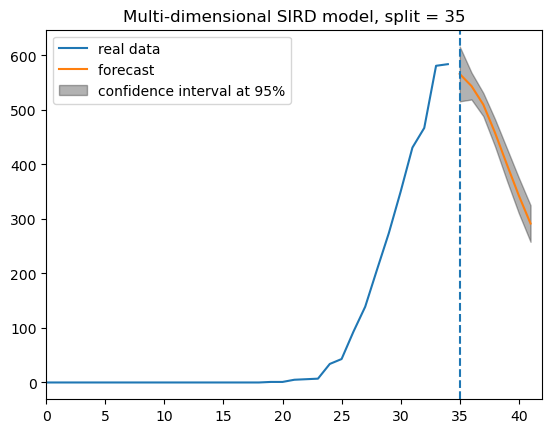

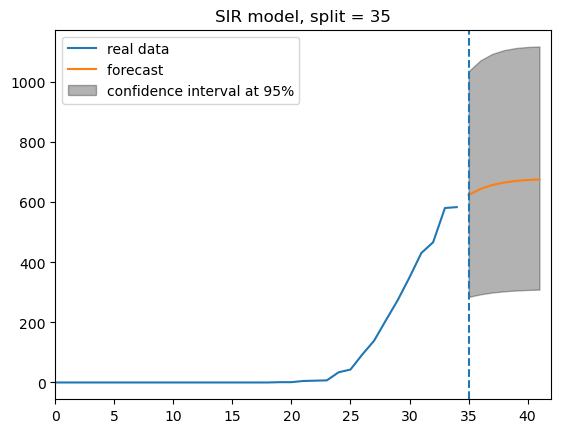

delta-method
[118.26793155 107.49171845  93.22458371  77.89327823  63.18856102
  50.07332176  38.94896794]


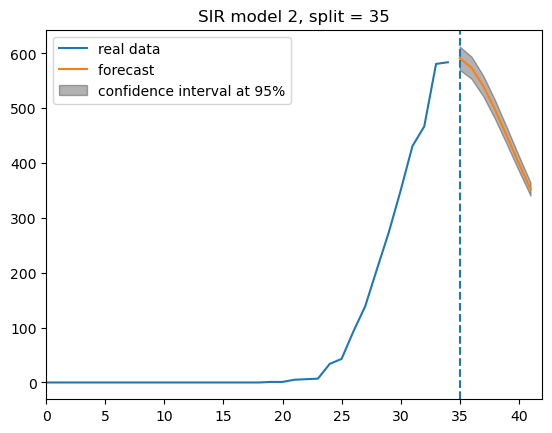

In [23]:
split = 35
reach=7
deaths_train=new_deaths[:split]
infected_train=n_infected[:split]
mob_train=mob_17_days_ahead[:split]
data_train=[deaths_train, infected_train, mob_train]
dates_of_pandemic_train=dates_of_pandemic[:split]
sird_multi=Multi_SIRD_model()
sird_multi.train(dates_of_pandemic_train, data_train)
sird_multi.plot(7, 0.05, title='Multi-dimensional SIRD model, split = '+ str(split))
sir=SIRD_model()
sir.train(dates_of_pandemic_train, data_train[0])
sir.plot(reach, 0.05, 'SIR model, split = '+ str(split))
sir2=SIRD_model_2()
sir2.train(dates_of_pandemic_train, data_train[0])
sir2.plot(reach, 0.05, 'SIR model 2, split = '+ str(split))



***Beta diminishes with the mobility***

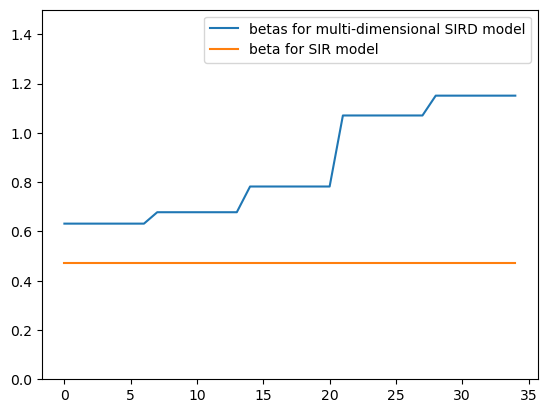

In [79]:
plt.plot(np.array(a*mobility +b)[:split], label = 'betas for multi-dimensional SIRD model')
plt.plot([beta for i in range(split)], label='beta for SIR model')
plt.ylim(0, 1.5)
plt.legend()

In [70]:
a,b,d=sird_multi.a, sird_multi.b, sird_multi.d
print(a,b,d)
beta, d = sir.beta, sir.d
print(beta, d)

-1.0595270085523072 0.6316866534525534 0.0015945202990232156
0.470251701549654 0.0006851111738590616


In [283]:
new_deaths_predicted_andalsoi=np.array(sir_for_optim_m(None, a, b, d, data_train[2]))
new_deaths_predicted=new_deaths_predicted_andalsoi[:len(new_deaths_predicted_andalsoi)//2]
n_infected_predicted=new_deaths_predicted_andalsoi[len(new_deaths_predicted_andalsoi)//2:]

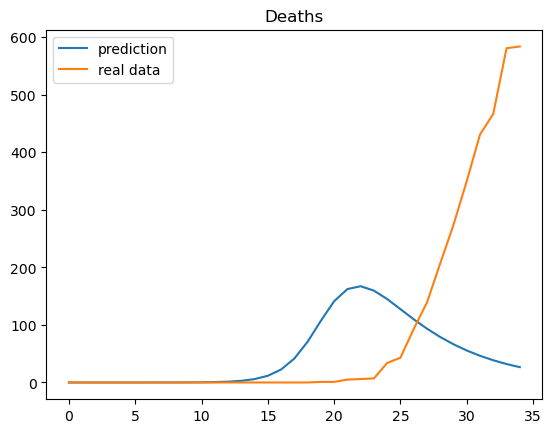

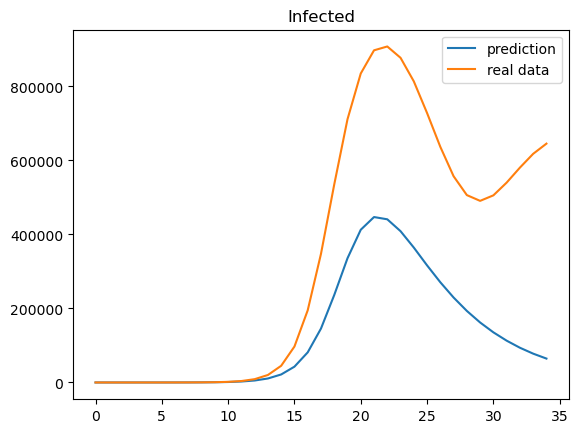

In [289]:
plt.plot(dates_of_pandemic_train, new_deaths_predicted, label='prediction')
plt.plot(dates_of_pandemic_train, new_deaths[:split], label='real data')
plt.title('Deaths')
plt.legend()
plt.show()

plt.plot(dates_of_pandemic_train, n_infected_predicted, label='prediction')
plt.plot(dates_of_pandemic_train, n_infected[:split], label='real data')
plt.title('Infected')
plt.legend()
plt.show()

delta-method


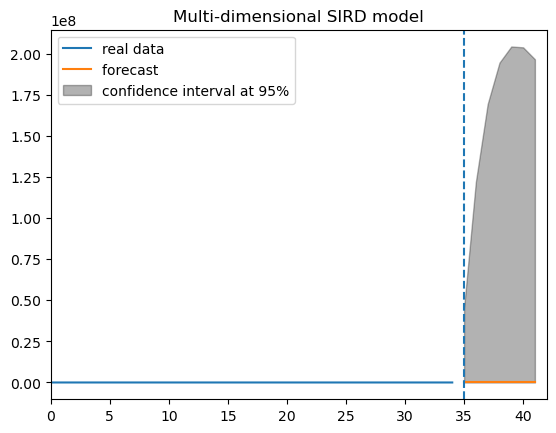

In [285]:
sird_multi.plot(7, 0.05, title='Multi-dimensional SIRD model')

In [286]:
raise ValueError('stop')

ValueError: stop

In [ ]:
mob_predicted=np.array([mobility[split] for i in range(reach)])

In [ ]:
s_0=1000000 -1
i_0=1
r_0=0
d_0=0
dt=0.001

In [ ]:
a, b, d= sird_multi.a, sird_multi.b, sird_multi.d 
a,b,d

(1.0495296107971617, 0.6188062264100698, 0.0028087240884069596)

In [ ]:
S,I,R,D=run_sir_m([s_0, i_0, r_0, d_0], a, b, 0.2, d, data[2][:split+reach], 0.001)


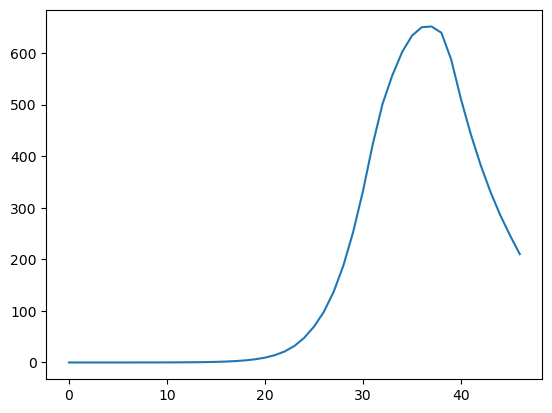

In [ ]:
plt.plot(sir_for_optim_m(None, a, b, d, data[2][:split+reach]))

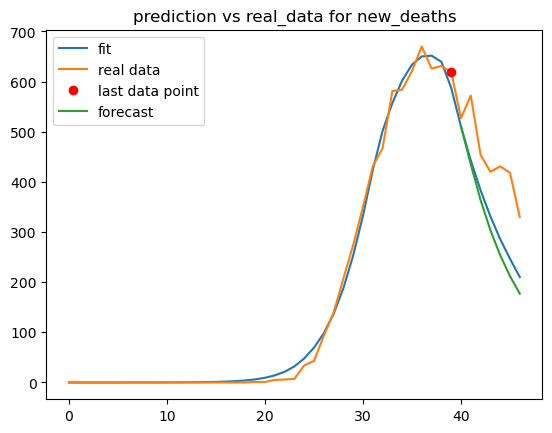

In [ ]:

plt.plot(np.concatenate((np.array([0]), differenciate(D))), label='fit')
plt.plot(new_deaths[:split+reach], label='real data')
plt.plot(split-1, new_deaths[split-1], 'ro', label='last data point')
plt.plot([i for i in range(split, split+reach)], pred, label='forecast')
plt.legend()
plt.title('prediction vs real_data for new_deaths')

plt.show()

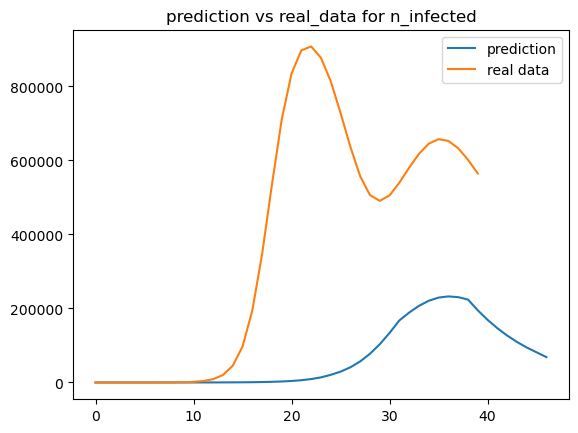

In [ ]:
plt.plot(I, label='prediction')
plt.plot(n_infected[:split], label='real data')
plt.legend()
plt.title('prediction vs real_data for n_infected')
plt.show()